In [73]:
# import all the things!
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV

In [3]:
X = pd.read_csv('../titanic.csv')
y = X.pop('Survived')

In [4]:
X.describe()
# age has missing values

/Users/Driz/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,index,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,2.000000,NaN,0.000000,0.000000,7.910400
50%,445.000000,446.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,667.500000,668.500000,3.000000,NaN,1.000000,0.000000,31.000000
max,890.000000,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# impute age with mean
X['Age'].fillna(X.Age.mean(), inplace=True)

# confirm
X.describe()

# ignoring categorical variables for right now

,index,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,445.000000,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,667.500000,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,890.000000,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# return just numeric variables ignoring 'object' datatypes
numeric_variables = list(X.dtypes[X.dtypes != 'object'].index)
X[numeric_variables].head()
# passenger id seems ignorable 

,index,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,0,1,3,22.0,1,0,7.2500
1,1,2,1,38.0,1,0,71.2833
2,2,3,3,26.0,0,0,7.9250
3,3,4,1,35.0,1,0,53.1000
4,4,5,3,35.0,0,0,8.0500


In [7]:
model = LogisticRegression()
model.fit(X[numeric_variables], y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# not shabby for a quick model to get going, but I think I can get a better score
model.score(X[numeric_variables], y)

0.70258136924803594

In [9]:
# do predictions to get to confusion matrix
# not sure what I was going with this
model.predict_proba

<bound method LogisticRegression.predict_proba of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>

In [10]:
# function to show descriptive stats on categorical variables
def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == 'object']].describe().to_html()))

In [11]:
describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [12]:
# drop variables I dont want in this
X.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [13]:
# change cabin variable to be first letter
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return 'None'
    
X['Cabin'] = X.Cabin.apply(clean_cabin)

In [14]:
# if data is missing returns none
X.Cabin.head()

0    None
1       C
2    None
3       C
4    None
Name: Cabin, dtype: object

In [15]:
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for variable in categorical_variables:
    X[variable].fillna('Missing', inplace=True)
    dummies = pd.get_dummies(X[variable], prefix=variable)
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [16]:
# to make sure there is no compression in the columns
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(X)

,index,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,0,3,22.000000,1,0,7.2500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,3,26.000000,0,0,7.9250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3,1,35.000000,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,3,35.000000,0,0,8.0500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,2,27.000000,0,0,13.0000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
887,887,1,19.000000,0,0,30.0000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
888,888,3,29.699118,1,2,23.4500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
889,889,1,26.000000,0,0,30.0000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [17]:
# that is a pretty good score, but it is using a lot of the data--overfit?
model = LogisticRegression()
model.fit (X, y)
model.score(X, y)
# print "C-stat", roc_auc_score(y, model.predict)

0.81032547699214363

In [18]:
# just checking in 
X.head()

,index,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [19]:
# just checking in
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

TEST TRAIN SPLIT

In [20]:
# lets set up a test and train set of data
x_train, x_test, y_train, y_test = train_test_split(X, y)

x_train.shape, x_test.shape

((668, 21), (223, 21))

In [21]:
# need to pluck only two of the three choices
pclass_dummies = pd.get_dummies(X['Pclass'])
pclass_dummies = pclass_dummies[[1, 2]]
pclass_dummies.columns = ['pclass=1', 'pclass=2']
pclass_dummies.head()

,pclass=1,pclass=2
0,0.0,0.0
1,1.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0


In [22]:
# need to pluck only two of the three choices
embarked_dummies = (X[['Embarked_Missing', 'Embarked_Q', 'Embarked_S']])
embarked_dummies.head()

,Embarked_Missing,Embarked_Q,Embarked_S
0,0.0,0.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [23]:
analytic_df = pclass_dummies.join(X['Sex_male'])
analytic_df = analytic_df.join(X[['Age', 'SibSp', 'Parch']])
analytic_df = analytic_df.join(embarked_dummies)
analytic_df['Child'] = analytic_df['Age'].apply(lambda x: 1 if x < 12 else 0)
analytic_df['Old Person'] = analytic_df['Age'].apply(lambda x: 1 if x > 50 else 0)
analytic_df.head()

,pclass=1,pclass=2,Sex_male,Age,SibSp,Parch,Embarked_Missing,Embarked_Q,Embarked_S,Child,Old Person
0,0.0,0.0,1.0,22.0,1,0,0.0,0.0,1.0,0,0
1,1.0,0.0,0.0,38.0,1,0,0.0,0.0,0.0,0,0
2,0.0,0.0,0.0,26.0,0,0,0.0,0.0,1.0,0,0
3,1.0,0.0,0.0,35.0,1,0,0.0,0.0,1.0,0,0
4,0.0,0.0,1.0,35.0,0,0,0.0,0.0,1.0,0,0


In [24]:
# shouldnt have any nulls cause I filled them earlier
print analytic_df.shape
analytic_df.dropna(inplace=True)
print analytic_df.shape

(891, 11)
(891, 11)


In [25]:
analytic_log = LogisticRegression()
analytic_log.fit(analytic_df, y)
analytic_log.score(analytic_df, y)

0.81032547699214363

In [26]:
# lets do a kbest on train data
kbest = SelectKBest(k='all')
kbest

SelectKBest(k='all', score_func=<function f_classif at 0x117722b90>)

In [27]:
results_kbest_all = kbest.fit_transform(analytic_df, y)
results_kbest_all

array([[ 0.,  0.,  1., ...,  1.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]])

In [28]:
kbest.scores_

array([  7.91364033e+01,   7.81480472e+00,   3.72405724e+02,
         4.35351609e+00,   1.11057220e+00,   5.96346384e+00,
         3.22216280e+00,   1.18463440e-02,   2.20754686e+01,
         1.13176268e+01,   4.67733759e-01])

In [29]:
logistic_regression_factory = LogisticRegression()
rfe_factory = RFE(estimator=logistic_regression_factory, step=1)

In [30]:
results_of_rfe = rfe_factory.fit_transform(analytic_df, y)
results_of_rfe

array([[ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.]])

Shows three model scores. KBest, rfe, and logistic regression on the dataframe. The models were run on the full dataset and there is probably some overfitting. Can retest models on train/test data. Not sure whether to further pursue kbest and rfe for this dataset or just switch over to gridsearch...

In [31]:
model_kbest_all_columns = LogisticRegression()
model_kbest_all_columns.fit(results_kbest_all, y)
model_kbest_all_columns.score(results_kbest_all, y)

0.81032547699214363

In [32]:
model_for_rfe_columns = LogisticRegression()
model_for_rfe_columns.fit(results_of_rfe, y)
model_for_rfe_columns.score(results_of_rfe, y)

0.78900112233445563

In [122]:
full_df = LogisticRegression()
full_df.fit(analytic_df.as_matrix(), y)
full_df.score(analytic_df.as_matrix(), y)

0.81032547699214363

Looks like my kbest and entire df have same results. Should go back and restrict k='all'.

In [34]:
# lets redo a kbest on train data with restricted columns
kbest = SelectKBest(k=4)
kbest

SelectKBest(k=4, score_func=<function f_classif at 0x117722b90>)

In [35]:
results_of_kbest4 = kbest.fit_transform(analytic_df, y)
results_of_kbest4

array([[ 0.,  1.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.],
       [ 1.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.]])

In [36]:
kbest.scores_

array([  7.91364033e+01,   7.81480472e+00,   3.72405724e+02,
         4.35351609e+00,   1.11057220e+00,   5.96346384e+00,
         3.22216280e+00,   1.18463440e-02,   2.20754686e+01,
         1.13176268e+01,   4.67733759e-01])

In [37]:
# showing a lower score with less variables
model_for_kbest4_columns = LogisticRegression()
model_for_kbest4_columns.fit(results_of_kbest4, y)
model_for_kbest4_columns.score(results_of_kbest4, y)

0.79012345679012341

Ok, moving back to logistic regression for now. Then will run it through a grid search. Going to do these models on train data.

In [124]:
x_train.shape, y_train.shape

((668, 4), (668,))

In [125]:
analytic_df.head()

,pclass=1,pclass=2,Sex_male,Age,SibSp,Parch,Embarked_Missing,Embarked_Q,Embarked_S,Child,Old Person
0,0.0,0.0,1.0,22.0,1,0,0.0,0.0,1.0,0,0
1,1.0,0.0,0.0,38.0,1,0,0.0,0.0,0.0,0,0
2,0.0,0.0,0.0,26.0,0,0,0.0,0.0,1.0,0,0
3,1.0,0.0,0.0,35.0,1,0,0.0,0.0,1.0,0,0
4,0.0,0.0,1.0,35.0,0,0,0.0,0.0,1.0,0,0


In [126]:
x_train.head()

,pclass=1,Sex_male,Old Person,Embarked_Missing
404,0.0,0.0,0,0.0
572,1.0,1.0,0,0.0
718,0.0,1.0,0,0.0
453,1.0,1.0,0,0.0
441,0.0,1.0,0,0.0


In [127]:
# this is now wrong since I re-ran it. Need to open a new notebook and start over
x_train.columns

Index([u'pclass=1', u'Sex_male', u'Old Person', u'Embarked_Missing'], dtype='object')

In [42]:
messy_model_analytic = LogisticRegression()

In [43]:
messy_model_analytic.fit(x_train, y_train)
messy_model_analytic.score(x_train, y_train)

0.81736526946107779

In [123]:
mess_predictions = messy_model_analytic.predict(x_train)
mess_predictions[0:5]

ValueError: X has 4 features per sample; expecting 21

In [ ]:
mess_predict_proba = messy_model_analytic.predict_proba(x_train)
mess_predict_proba[0:]

In [ ]:
confusion_matrix(y_train, mess_predictions)

In [ ]:
print classification_report(y_train, mess_predictions)

In [ ]:
sns.heatmap(confusion_matrix(y_train, mess_predictions), annot=True)

That is a pretty good score. It also contains quite a lot of columns. Could it be overfit? Should I move into a grid search before running my model on my test data. Also, I may pluck some x variables out for fun and see how it alters my score. Also, need confusion matrix at some point. 

In [44]:
xs = x_train[['Sex_female', 'Age', 'Embarked_Q', 
             'Cabin_F','Pclass']]

In [45]:
paired_down_model = LogisticRegression()

In [46]:
# not as good of a score with my plucked x variables (but still decent)
paired_down_model.fit(xs, y_train)
paired_down_model.score(xs, y_train)

0.79640718562874246

In [50]:
predictions = paired_down_model.predict(xs)
predictions[0:5]

array([0, 0, 0, 1, 0])

In [54]:
predict_proba = paired_down_model.predict_proba(xs)
predict_proba[0:5]

array([[ 0.80302019,  0.19697981],
       [ 0.93043005,  0.06956995],
       [ 0.84992995,  0.15007005],
       [ 0.36695183,  0.63304817],
       [ 0.88388061,  0.11611939]])

In [52]:
xs.head(1)

,Sex_female,Age,Embarked_Q,Cabin_F,Pclass
278,0.0,7.0,1.0,0.0,3


The predict_proba shows the probability each variable points to whether or not someone survived. First column predicts the variables possible association to death and second life.

Going to do a confusion matrix now to check for accuracy and evaluate model fit.

In [56]:
confuse_matrix_1 = np.array(confusion_matrix(y_train, predictions))

confusion = pd.DataFrame(confuse_matrix_1, index=['is_dead', 'is_alive'],
                         columns=['predicted_dead', 'predicted_alive'])

confusion

,predicted_dead,predicted_alive
is_dead,356,58
is_alive,78,176


The confusion matrix above details the predictions of my model. Its shows that it correctly predicted 356 correctly dead and 176 alive. It returned 78 false positives and 58 false negatives. 

Let's plot the ROC curve to get a visual representation of the confusion matrix

(array([ 0.        ,  0.00241546,  0.00241546,  0.00241546,  0.00241546,
        0.00241546,  0.00241546,  0.00241546,  0.00241546,  0.00241546,
        0.00241546,  0.00241546,  0.00241546,  0.00241546,  0.00241546,
        0.00241546,  0.00241546,  0.00241546,  0.00241546,  0.00241546,
        0.00241546,  0.00241546,  0.00241546,  0.00241546,  0.00241546,
        0.00241546,  0.00241546,  0.00241546,  0.00241546,  0.00241546,
        0.00483092,  0.00483092,  0.00483092,  0.00483092,  0.00483092,
        0.00483092,  0.00724638,  0.00724638,  0.00724638,  0.00724638,
        0.01207729,  0.01207729,  0.01449275,  0.01449275,  0.01690821,
        0.01690821,  0.01690821,  0.01932367,  0.01932367,  0.02415459,
        0.03381643,  0.03381643,  0.03623188,  0.03623188,  0.0410628 ,
        0.0410628 ,  0.04589372,  0.04589372,  0.04589372,  0.04830918,
        0.05072464,  0.0531401 ,  0.05797101,  0.05797101,  0.06280193,
        0.07246377,  0.07487923,  0.07971014,  0.08454106,  0.0

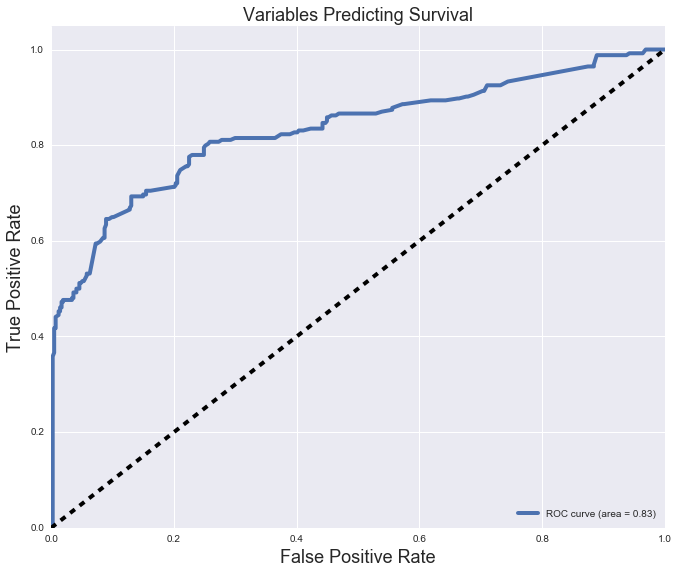

In [60]:
y_score = paired_down_model.decision_function(xs)

FPR = dict()
TPR = dict()
ROC_AUC = dict() # {}

# For class 1, find the area under the curve

print roc_curve(y_train, y_score)

FPR[1], TPR[1], _ = roc_curve(y_train, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])


# Plot of a ROC curve for class 1 (Survival)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Variables Predicting Survival', fontsize=18)
plt.legend(loc="lower right")
plt.show();

The greater the area under the curve shows the higher the ratio of true positives to false positives.

In [66]:
acc = accuracy_score(y_train, predictions)
acc

0.79640718562874246

In [67]:
print(classification_report(y_train, predictions))

             precision    recall  f1-score   support

          0       0.82      0.86      0.84       414
          1       0.75      0.69      0.72       254

avg / total       0.79      0.80      0.79       668



Even though I have higher scoring models than this one I am going to go ahead and run it on my test data just for practice.

The 0 and 1 on the left column indicate the two classes predicted by the model. For models with multiple classes there would be more rows and labels.

Each of the columns indicate an important metric for evaluating classification model performance.

Precision is the ability of the classifier to avoid mislabeling when the observation belongs in another class.

Precision = True Positives / (True Positives + False Positives)

A precision score of 1 indicates that the classifier never mistakenly added observations from another class. A precision score of 0 would mean that the classifier misclassified every instance of the current class.

recall is the ability of the classifier to correctly identify all observations in the current class.

Recall = True Positives / (True Positives + False Negatives)

A recall score of 1 indicates that the classifier correctly predicted (found) all observations of the current class (by implication, no false negatives, or misclassifications of the current class). A recall score of 0 alternatively means that the classifier missed all observations of the current class.

f1-score is the harmonic mean of the precision and recall. The harmonic mean is used here rather than the more conventional arithmetic mean because the harmonic mean is more appropriate for averaging rates.

F1-Score = 2 * (Precision * Recall) / (Precision + Recall)

The f1-score's best value is 1 and worst value is 0, like the precision and recall scores. It is a useful metric for taking into account both measures at once.

support is simply the number of observations of the labelled class.

In [69]:
xs_test = x_test[['Sex_female', 'Age', 'Embarked_Q', 
             'Cabin_F','Pclass']]

In [70]:
print 'Using paired_down_model with test data we get:', paired_down_model.score(xs_test, y_test)

Using paired_down_model with test data we get: 0.811659192825


0.79640718562874246 <-- was score from train data. When compared to test data, test data did have a higher score. 

It's not surprising that 'Sex_female', 'Age', and 'Pclass' variables did well in identifying whether or not a passenger survived. Through historical records we know that women, children, and first class passengers where given priority when boarding life boats.

I will do a grid search on the train data to see what kind of scores return.

In [71]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 5, .001]
}
paired_down_model = LogisticRegression()

In [75]:
grid_search = GridSearchCV(estimator=paired_down_model,
                          param_grid=parameters,
                          verbose=10,
                          cv=6)
grid_search

GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 5, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [76]:
grid_search.fit(xs, y_train)

Fitting 6 folds for each of 10 candidates, totalling 60 fits
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.767857 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.803571 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.747748 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.819820 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.756757 -   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ...................... penalty=l1, C=0.1, score=0.828829 -   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


[CV] ....................... penalty=l2, C=10, score=0.765766 -   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.819820 -   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.756757 -   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ....................... penalty=l2, C=10, score=0.828829 -   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] ........................ penalty=l1, C=5, score=0.776786 -   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] ........................ penalty=l1, C=5, score=0.821429 -   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] ........................ penalty=l1, C=5, score=0.765766 -   0.0s
[CV] penalty=l1, C=5 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s finished


GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 5, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [77]:
grid_search.best_score_

0.79640718562874246

In [78]:
grid_search.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
grid_search.best_estimator_.fit(xs, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
grid_search.best_estimator_.score(xs, y_train)

0.79491017964071853

In [81]:
predictors = grid_search.best_estimator_.predict(xs)

In [115]:
confusion_matrix(y_train, predictors)

array([[260, 151],
       [173,  84]])

In [117]:
confuse_matrix_1 = np.array(confusion_matrix(y_train, predictions))

confusion = pd.DataFrame(confuse_matrix_1, index=['is_dead', 'is_alive'],
                         columns=['predicted_dead', 'predicted_alive'])

confusion

,predicted_dead,predicted_alive
is_dead,262,149
is_alive,172,85


In [84]:
print classification_report(y_train, predictors)

             precision    recall  f1-score   support

          0       0.82      0.86      0.84       414
          1       0.75      0.69      0.72       254

avg / total       0.79      0.79      0.79       668



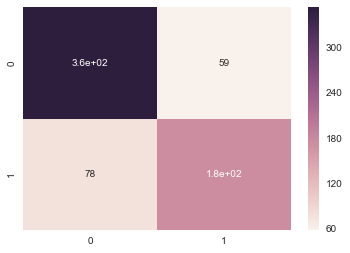

In [85]:
sns.heatmap(confusion_matrix(y_train, predictors), annot=True)

Before I accept this model I want to go back and restrain my x variables to be old age, male, first class, and missing embarked location.

In [86]:
analytic_df.head(1)

,pclass=1,pclass=2,Sex_male,Age,SibSp,Parch,Embarked_Missing,Embarked_Q,Embarked_S,Child,Old Person
0,0.0,0.0,1.0,22.0,1,0,0.0,0.0,1.0,0,0


Need to make a train test split on this dataframe. Then I will run a logistic regression on my plucked out x variables.

In [99]:
data_plucked = analytic_df[['pclass=1', 'Sex_male', 'Old Person', 'Embarked_Missing']]

In [100]:
x_train, x_test, y_train, y_test = train_test_split(data_plucked, y)

In [101]:
x_train.shape, y_train.shape

((668, 4), (668,))

In [102]:
x_test.shape, y_test.shape

((223, 4), (223,))

In [103]:
pluck_model = LogisticRegression()

In [104]:
pluck_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [105]:
pluck_model.score(x_train, y_train)

0.78892215568862278

In [106]:
pluck_model_lasso = LogisticRegression(penalty='l1')

In [107]:
pluck_model_lasso.fit(x_train, y_train)
pluck_model_lasso.score(x_train, y_train)

0.78892215568862278

In [109]:
predict = pluck_model.predict(x_train)
predict[0:5]

array([1, 0, 0, 0, 0])

In [110]:
predict_proba = pluck_model.predict_proba(x_train)
predict_proba[0:]

array([[ 0.32264311,  0.67735689],
       [ 0.59633327,  0.40366673],
       [ 0.85520737,  0.14479263],
       ..., 
       [ 0.32264311,  0.67735689],
       [ 0.85520737,  0.14479263],
       [ 0.32264311,  0.67735689]])

Before modeling on my test data, let's do a confusion matrix

In [118]:
confusion_matrix(y_train, predict)

array([[352,  59],
       [ 82, 175]])

In [120]:
confuse_matrix_org = np.array(confusion_matrix(y_train, predict))

confusion_org = pd.DataFrame(confuse_matrix_org, index=['is_dead', 'is_alive'],
                         columns=['predicted_dead', 'predicted_alive'])

confusion_org

,predicted_dead,predicted_alive
is_dead,352,59
is_alive,82,175


The above confusion matrix shows that there were 352 true negatives predicted by the model, 59 false negatives, 82 false positives, and 175 true positives. So, predicting that 59 people survived when they were in fact dead is not too shabby for my model. Let's check precision with a classification report.

In [112]:
print classification_report(y_train, predict)

             precision    recall  f1-score   support

          0       0.81      0.86      0.83       411
          1       0.75      0.68      0.71       257

avg / total       0.79      0.79      0.79       668



Overall good scores for predicting death. On the other hand it may not be the best model if you are a glass half full kind of person.

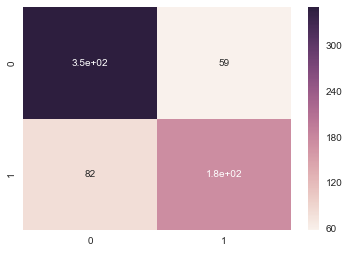

In [113]:
sns.heatmap(confusion_matrix(y_train,predict), annot=True)

Let's run test data through this model now and see what happens to the scores

In [121]:
pluck_model.score(x_test, y_test)

0.78026905829596416

After passing the test data through the model it shows a lower score. This may point to some overfitting of the data. Will go back up and re-evaluate some of my earlier models to make sure I ran them all on train-test data.

Conclusion:

So, let's recap: I have made three different models. All vary in their predictive power. Best score has been with messy_model_analytic (0.817 on train and ___ on test___). Blah, blah, blah--write more here.